# This part is for dataloader test for improved cycle gan

In [1]:
# Import packages
import time
from options.train_options import TrainOptions
from data import create_dataset
from models import create_model, improved_losses
from util.visualizer import Visualizer
import sys
import os
import torch
import numpy as np
# Import plt
import matplotlib.pyplot as plt



In [2]:
# Simulate command-line arguments
sys.argv = [
    'train.py',  # script name, traditionally argv[0]
    '--dataroot', '/home/frozen/CV_FinalProject/Cell_cycleGAN/Training_Datasets/training_dataset_tiledGOWT_Fakulty_Inverse',
    '--name', 'cycle_gan',
    '--results_dir', '/home/frozen/Experiments_Repitition/Cell_cycleGAN/results/training_dataset_tiledGOWT_Fakulty_Inverse',
    '--model', 'cycle_gan',
    '--batch_size', '24',
    '--n_epochs', '200',
    '--n_epochs_decay', '200',
    '--continue_train',
    '--epoch_count', '367',
    '--dataset_mode', 'improvedunaligned',
    '--direction', 'AtoB',
    '--model', 'seg_cycle_gan',
    '--input_nc', '1',
    '--output_nc', '3',
]

# Define the options for training
opt = TrainOptions().parse()



----------------- Options ---------------
               batch_size: 24                            	[default: 1]
                    beta1: 0.5                           
          checkpoints_dir: /home/frozen/Experiments_Repitition/Cell_cycleGAN/results/training_dataset_tiledGOWT_Fakulty_Inverse/cycle_gan	[default: None]
           continue_train: True                          	[default: False]
                crop_size: 128                           
                 dataroot: /home/frozen/CV_FinalProject/Cell_cycleGAN/Training_Datasets/training_dataset_tiledGOWT_Fakulty_Inverse	[default: None]
             dataset_mode: improvedunaligned             	[default: unaligned]
                direction: AtoB                          	[default: BtoA]
              display_env: main                          
             display_freq: 400                           
               display_id: 1                             
            display_ncols: 4                             
          

In [3]:
# Create the dataset
dataset = create_dataset(opt)

# Check Length of dataset
print('The length of the dataset is:', len(dataset))


dataset [ImprovedUnalignedDataset] was created
The length of the dataset is: 576


In [13]:
# Get one sample from the dataset
sample = next(iter(dataset)) 


# Display the sample
sample_A = sample['A']
sample_B = sample['B']
sample_A_GT = sample['A_GT']

# Print paths of first A and A_GT
print('Path of A:', sample['A_paths'][0])
print('Path of A_GT:', sample['A_GT_paths'][0])

Path of A: /home/frozen/CV_FinalProject/Cell_cycleGAN/Training_Datasets/training_dataset_tiledGOWT_Fakulty_Inverse/trainA/inverted_01_115.tiff
Path of A_GT: /home/frozen/CV_FinalProject/Cell_cycleGAN/Training_Datasets/training_dataset_tiledGOWT_Fakulty_Inverse/trainA_GT/01_115.tiff


In [14]:
# Denormalize the image from [0,1] to [0,255]
sample_A = (sample_A + 1)/2 * 255.0
sample_B = (sample_B + 1)/2 * 255.0
sample_A_GT = (sample_A_GT + 1)/2 * 255.0

# Reshape the tensors
sample_A_Vis = sample_A[0].permute(1,2,0)
sample_A_Vis = sample_A_Vis.squeeze()
sample_B_Vis = sample_B[0].permute(1,2,0)
sample_A_GT_Vis = sample_A_GT[0].permute(1,2,0)

# Convert the tensor to numpy and convert data type to uint8
sample_A_Vis = sample_A_Vis.numpy().astype(np.uint8)
sample_B_Vis = sample_B_Vis.numpy().astype(np.uint8)
sample_A_GT_Vis = sample_A_GT_Vis.numpy().astype(np.uint8)

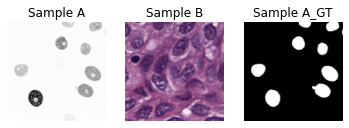

In [15]:


# Display images
plt.figure()
plt.subplot(1, 3, 1)
# Display sample A as grayscale
plt.imshow(sample_A_Vis, cmap='gray')
plt.title('Sample A')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(sample_B_Vis)
plt.title('Sample B')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(sample_A_GT_Vis)
plt.title('Sample A_GT')
plt.axis('off')

plt.show()


In [7]:
# Test the model - improved_losses

# Test GT loss
print('Testing GT loss')

GT_loss = improved_losses.GT_Loss(sample_A, sample_A_GT)

print('The GT loss is:', GT_loss.item())

Testing GT loss
The GT loss is: 5.7042874686885625e-05


In [8]:
# Test ColorVariance loss
print('Testing ColorVariation loss')

# Use sample A and sample B as input
ColorVariance_loss = improved_losses.ColorVariation_Loss(sample_A, sample_B)

print('The ColorVariance loss is:', ColorVariance_loss.item())

Testing ColorVariation loss
The ColorVariance loss is: 0.9907666124343842


In [9]:
# Test HSV loss
print('Testing HSV loss')

# Use sample A and sample B as input
HSV_loss = improved_losses.HSV_Loss(sample_B, sample_B)

print('The HSV loss is:', HSV_loss.item())

Testing HSV loss
The HSV loss is: 0.0


In [10]:
# Create the model
model = create_model(opt)

# Set up the model
model.setup(opt)


initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
model [SegCycleGANModel] was created
loading the model from /home/frozen/Experiments_Repitition/Cell_cycleGAN/results/training_dataset_tiledGOWT_Fakulty_Inverse/cycle_gan/latest_net_G_A.pth


RuntimeError: Error(s) in loading state_dict for ResnetGenerator:
	size mismatch for model.1.weight: copying a param with shape torch.Size([64, 3, 7, 7]) from checkpoint, the shape in current model is torch.Size([64, 1, 7, 7]).

In [ ]:
# Training Loop
total_iters = 0
for epoch in range(opt.epoch_count, opt.n_epochs + opt.n_epochs_decay + 1):
    epoch_start_time = time.time()
    iter_data_time = time.time()
    epoch_iter = 0

    # Update learning rate
    model.update_learning_rate()

    # Iterate over dataset
    for i, data in enumerate(dataset):
        iter_start_time = time.time()
        if total_iters % opt.print_freq == 0:
            t_data = iter_start_time - iter_data_time

        total_iters += opt.batch_size
        epoch_iter += opt.batch_size
        model.set_input(data)
        model.optimize_parameters()

        if total_iters % opt.display_freq == 0:
            save_result = total_iters % opt.update_html_freq == 0
            model.compute_visuals()
            

        if total_iters % opt.print_freq == 0:
            errors = model.get_current_errors()
            t = (time.time() - iter_start_time) / opt.batch_size
            

        if total_iters % opt.save_latest_freq == 0:
            print('saving the latest model (epoch %d, total_iters %d)' % (epoch, total_iters))
            save_suffix = 'iter_%d' % total_iters if opt.save_by_iter else 'latest'
            model.save_networks(save_suffix)

        iter_data_time = time.time()
    if epoch % opt.save_epoch_freq == 0:
        print('saving the model at the end of epoch %d, iters %d' % (epoch, total_iters))
        model.save_networks('latest')
        model.save_networks(epoch)

    print('End of epoch %d / %d \t Time Taken: %d sec' % (epoch, opt.n_epochs + opt.n_epochs_decay, time.time() - epoch_start_time))
    model.update_learning_rate()

learning rate 0.0000169 -> 0.0000164


/opt/conda/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[24, 1, 134, 134] to have 3 channels, but got 1 channels instead